In [45]:
import os
import argparse
from typing import List
from datetime import datetime
from dataclasses import dataclass
import data
import network
import solver
import joblib
import json
import torch

import matplotlib.pyplot as plt
import numpy as np
import time

In [46]:
def gram_schmidt(N, K):
    """
    Given the dimension space dimension N, generate K random vectors and its orthogonal spans
    """
    
    def proj(u,v):
        """
        Return projection of v to u
        """
        return np.dot(v,u)/np.dot(u,u) * u
    
    V=np.random.normal(loc = 0., scale = 1, size = (K, N))
    U=np.zeros_like(V)
    
    ## Initialise u1 to v1
    U[0] = V[0]
    
    ## Gram-schomidt process
    for k in range(1,K):
        projection_terms = [proj(U[i], V[k]) for i in range(k)]
        U[k] = V[k] - np.sum(projection_terms, axis=0)
    
    return V, U
        

def control_VS(VT, angle):
    dim = len(VT)
    VT_norm = VT/np.linalg.norm(VT)
    c = np.cos(angle)
    a = np.random.normal(loc = 0., scale = 1, size = (dim))
    b = np.random.normal(loc = 0., scale = 1, size = (dim))
    h = (b-a) - np.dot((b-a),VT_norm)*VT_norm
    v = np.cos(angle)*VT_norm + np.sin(angle)*h/np.linalg.norm(h)
    
    return v

In [47]:
num_task = 4
seq_len = 1
input_dim = 1000
nums_iter_base = np.array([0, 100000])
nums_iter = np.array([100000, 100000])
update_frequency = 1000

In [48]:
results_ode_base= []
results_sim_base = []
results_ode= []
results_sim = []
lr_v = 1.
lr_wc = 1.
for num_task in [2,4,8]:
    vt = np.ones(num_task)
    VT_i= np.array(vt)
    VT_i *= np.sqrt(num_task)/np.linalg.norm(VT_i)
    VT_ode=VT_i.copy()
    VS_sim = control_VS(VT_i, np.pi/4) * np.sqrt(num_task)
    VS_ode = VS_sim.copy()
    VS_sim_base = VS_sim.copy()
    VS_ode_base = VS_sim.copy()
    
    _, WT_i =gram_schmidt(input_dim, num_task)
    WT_ode = WT_i.copy()
    WS_i = WT_i.copy()

    WS_sim = np.random.normal(0, .1, (num_task,input_dim))
    WS_sim = np.divide(WS_sim * np.sqrt(input_dim),
                        np.linalg.norm(WS_i, axis=1)[:, None])
    WS_ode = WS_sim.copy()
    WS_ode_base = WS_sim.copy()
    WS_sim_base = WS_sim.copy()
    ode_solver_nid= solver.HRLODESolver(N = input_dim, seq_length = seq_len,
                                                                 VS = VS_ode, VT= VT_i, WS=WS_ode, WT = WT_ode,
                                   lr_ws = [1., lr_wc], lr_v = lr_v, V_norm = 0)
    
    solver_nid = solver.CurriculumCompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len,
                                                                 num_task= num_task, identical = False,
                                                                 VS = VS_sim, VT= VT_i, WS=WS_sim, WT = WT_i)
    solver_nid.train(lr = {'lr_w':1., 'lr_wc':lr_wc, 'lr_vc': lr_v},num_iter= nums_iter, update_frequency = update_frequency)
    ode_solver_nid.train(nums_iter= nums_iter, update_frequency = update_frequency)
    
    ode_solver_nid_base= solver.HRLODESolver(N = input_dim, seq_length = seq_len,
                                                                 VS = VS_ode_base, VT= VT_i, WS=WS_ode_base, WT = WT_ode,
                                   lr_ws = [1., lr_wc], lr_v = lr_v, V_norm = 0)
    
    solver_nid_base = solver.CurriculumCompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len,
                                                                 num_task= num_task, identical = False,
                                                                 VS = VS_sim_base, VT= VT_i, WS=WS_sim_base, WT = WT_i)
    solver_nid_base.train(lr = {'lr_w':1., 'lr_wc':lr_wc, 'lr_vc': lr_v},num_iter= nums_iter_base, update_frequency = update_frequency)
    ode_solver_nid_base.train(nums_iter= nums_iter_base, update_frequency = update_frequency)

    results_ode_base.append(ode_solver_nid_base)
    results_sim_base.append(solver_nid_base)
    results_ode.append(ode_solver_nid)
    results_sim.append(solver_nid)
"""
solver_nid.setup_train()
solver_nid.setup_history(it)
ode_solver_nid.update_frequency=1
ode_solver_nid._setup_history([0,it])
ode_solver_nid._init_params()
DRS=[]
for i in range(it):
    sim_VS_pre = solver_nid.VS
    sim_Q_pre = solver_nid.WS@solver_nid.WS.T/solver_nid.input_dim
    sim_R_pre = solver_nid.WS@solver_nid.WT.T/solver_nid.input_dim
    solver_nid.step()
    solver_nid.update_history(i)
    sim_VS_post = solver_nid.VS

    sim_Q_post = solver_nid.WS@solver_nid.WS.T/solver_nid.input_dim
    sim_R_post = solver_nid.WS@solver_nid.WT.T/solver_nid.input_dim
    
    DV = solver_nid.dv
    DR = sim_R_post -sim_R_pre
    ode_solver_nid.train_iter = i
    ode_solver_nid._step2(True, DV=DV, DQ=None, DR=None)
    #if np.all(DR) !=0:
    DRS.append(DR)
"""

'\nsolver_nid.setup_train()\nsolver_nid.setup_history(it)\node_solver_nid.update_frequency=1\node_solver_nid._setup_history([0,it])\node_solver_nid._init_params()\nDRS=[]\nfor i in range(it):\n    sim_VS_pre = solver_nid.VS\n    sim_Q_pre = solver_nid.WS@solver_nid.WS.T/solver_nid.input_dim\n    sim_R_pre = solver_nid.WS@solver_nid.WT.T/solver_nid.input_dim\n    solver_nid.step()\n    solver_nid.update_history(i)\n    sim_VS_post = solver_nid.VS\n\n    sim_Q_post = solver_nid.WS@solver_nid.WS.T/solver_nid.input_dim\n    sim_R_post = solver_nid.WS@solver_nid.WT.T/solver_nid.input_dim\n    \n    DV = solver_nid.dv\n    DR = sim_R_post -sim_R_pre\n    ode_solver_nid.train_iter = i\n    ode_solver_nid._step2(True, DV=DV, DQ=None, DR=None)\n    #if np.all(DR) !=0:\n    DRS.append(DR)\n'

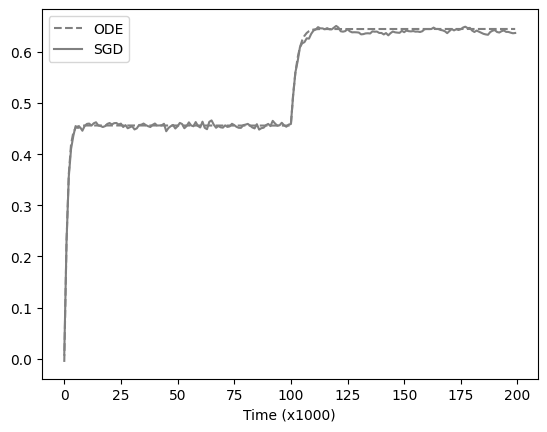

In [49]:
plt.plot(np.concatenate([ode_solver_nid.history['phase1']['overlap_tilde'], \
                         ode_solver_nid.history['phase2']['overlap_tilde']]), c='gray', ls= '--',label = 'ODE')
plt.plot(solver_nid.history['overlap_tilde'], c= 'gray', label = 'SGD')

plt.ylabel('')
plt.xlabel('Time (x1000)')
plt.legend()

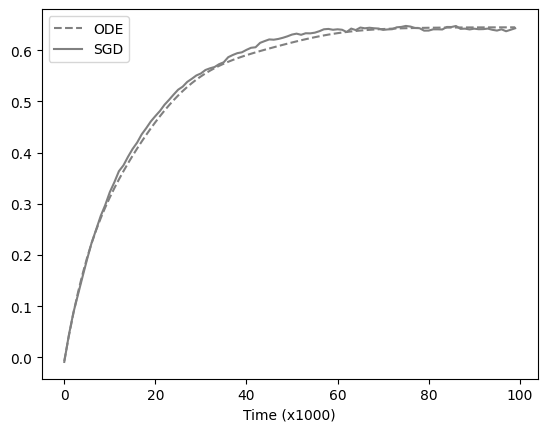

In [50]:
plt.plot(np.concatenate([ode_solver_nid_base.history['phase1']['overlap_tilde'], \
                         ode_solver_nid_base.history['phase2']['overlap_tilde']]), c='gray', ls= '--',label = 'ODE')
plt.plot(solver_nid_base.history['overlap_tilde'], c= 'gray', label = 'SGD')

plt.ylabel('')
plt.xlabel('Time (x1000)')
plt.legend()

In [25]:
pert= solver.HRLODESolver(N = input_dim, seq_length = seq_len,
                                    VS = ode_solver_nid.VS, VT= VT_perturbed, 
                          WS=ode_solver_nid.WS, WT = ode_solver_nid.WT,
                                   lr_ws = [1., lr_wc], lr_v = lr_v, V_norm = 0)
pert.train(nums_iter= np.array([0, 100000]), update_frequency = update_frequency)

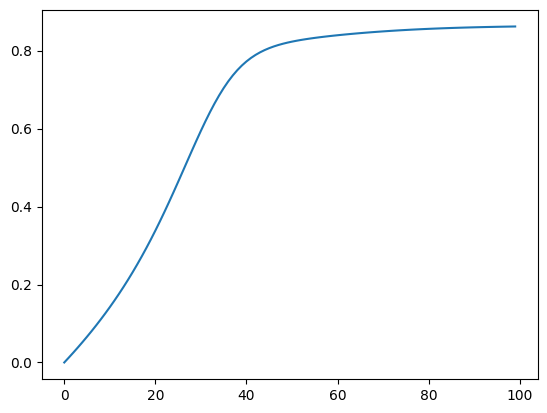

In [27]:
plt.plot(pert.history['phase2']['overlap_tilde'])

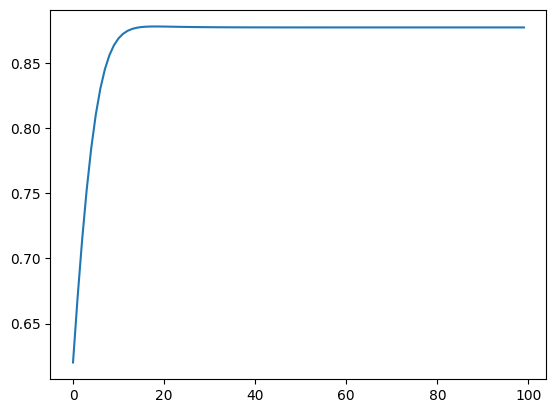

In [26]:
plt.plot(ode_solver_nid.history['phase2']['overlap_tilde'])

In [6]:
a=[]
b= []
for i in range(1000):
    x = np.random.normal(loc=0.0,
                     scale=1.0,
                     size=(num_task, input_dim,
                                       seq_len))
    (y, y_sign, y_hat,
         y_hat_sign), (y_tilde, y_tilde_hat, y_tilde_sign,
                       y_tilde_hat_sign) = solver_nid.inference(x)
    b.append(y_tilde_sign == y_tilde_hat_sign)

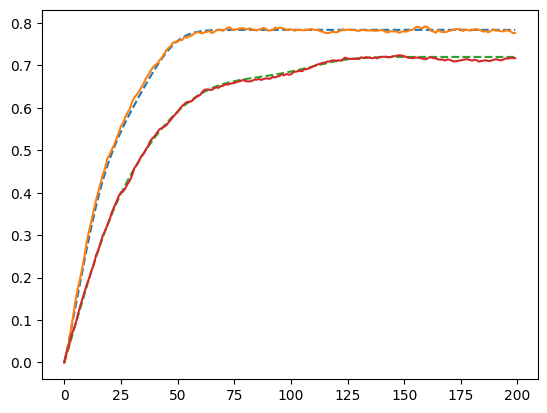

In [6]:
for i in range(2):
    plt.plot(results_ode[i].history['phase2']['overlap_tilde'], ls = '--')
    plt.plot(results_sim[i].history['overlap_tilde'])


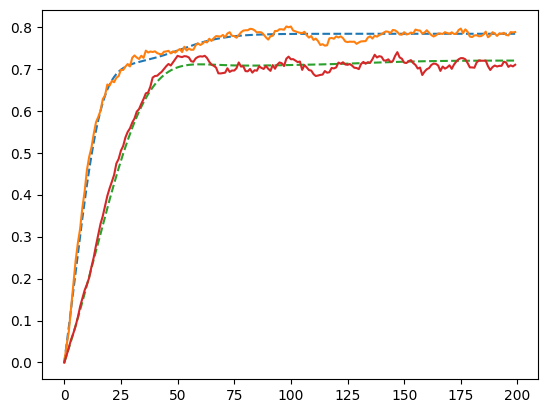

In [13]:
for i in range(2):
    plt.plot(results_ode[i].history['phase2']['overlap'][:,3], ls = '--')
    plt.plot(results_sim[i].history['overlap'][:,3])


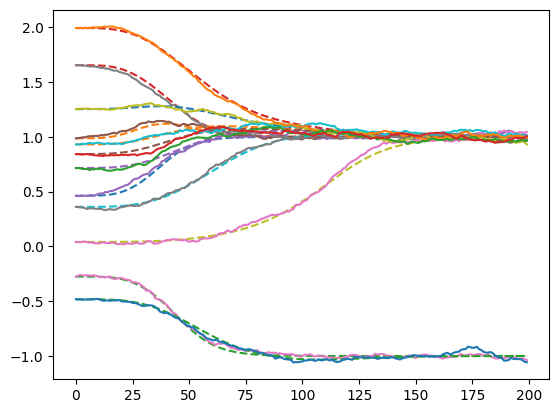

In [14]:
for i in range(2):
    plt.plot(results_ode[i].history['phase2']['VS'], ls = '--')
    plt.plot(results_sim[i].history['VS'])


NameError: name 'solver_nid' is not defined

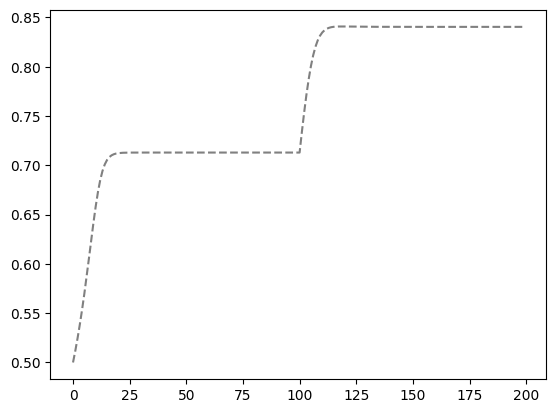

In [36]:
plt.plot(np.concatenate([ode_solver_nid.history['phase1']['P_tilde']
        ,ode_solver_nid.history['phase2']['P_tilde']]), ls= '--', c= 'gray')
plt.plot(solver_nid.history['P_tilde'], c= 'gray')

In [9]:
ode_solver_nid.history['phase2']['Q'][:,0,0]

array([1., 1., 1., ..., 1., 1., 1.])

In [35]:
np.linalg.norm(sim_R_post)

1.3058188394206574

In [9]:
np.linalg.norm(sim_R_post)

1.2966641038548354

In [13]:
DR

array([[-2.41368459e-04,  6.63557407e-04,  9.39364960e-05,
         3.10719723e-04],
       [-1.10000659e-04,  5.71243351e-04, -5.26536825e-04,
         7.35365200e-04],
       [-1.82078808e-04, -1.56042173e-04,  3.48539843e-04,
         4.12251995e-04],
       [-9.95957671e-04, -4.93559096e-04,  3.49904908e-04,
        -5.58180264e-04]])

In [7]:
# Curriculum version
#for i,vt in enumerate([np.random.normal(0,1, (4)), np.random.normal(0,1, (4)), np.random.normal(0,1, (4)), np.random.normal(0,1, (4))]):
vt = [.1,.1,.1,.1,]
results = {}

for lr_v in [1]:
    results[lr_v]={}
    for lr_wc in [1]: 
        results[lr_v][lr_wc] = []
        for s in np.arange(1):
            VT_i= np.array(vt)
            VT_ode=VT_i.copy()
            VS_i =control_VS(VT_i, np.pi/4)
            VS_ode = VS_i.copy()
            _, WT_i =gram_schmidt(input_dim, num_task)
            WT_ode = WT_i.copy()
            WS_i = np.random.normal(0, .1, (num_task,input_dim))
            WS_i = np.divide(WS_i * np.sqrt(input_dim),
                                np.linalg.norm(WS_i, axis=1)[:, None])
            WS_ode = WS_i.copy()
            ode_solver_nid= solver.HRLODESolver(N = input_dim, seq_length = seq_len,
                                                                         VS = VS_ode, VT= VT_ode, WS=WS_ode, WT = WT_ode,
                                           lr_ws = [1., lr_wc], lr_v = lr_v )
            solver_nid = solver.CurriculumCompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len,
                                                                         num_task= num_task, identical = False,
                                                                         VS = VS_i, VT= VT_i, WS=WS_i, WT = WT_i)
            solver_nid.train(lr = {'lr_w':1., 'lr_wc':lr_wc, 'lr_vc': lr_v},num_iter= nums_iter, update_frequency = update_frequency)
            ode_solver_nid.train(nums_iter= nums_iter, update_frequency = update_frequency)
            results[lr_v][lr_wc].append(solver_nid)


/nfs/nhome/live/jlee/rotation_saxe/composite_learning/solver/simple_hrl_solver.py:490: RuntimeWarning: invalid value encountered in sqrt
  dR = self.lr_w1 / self.N / sqrt2pi * (np.diag(np.sqrt(
/nfs/nhome/live/jlee/rotation_saxe/composite_learning/solver/simple_hrl_solver.py:491: RuntimeWarning: invalid value encountered in sqrt
  self.S)) + np.diag(self.R) / np.diag(np.sqrt(self.Q))) * np.power(
/nfs/nhome/live/jlee/rotation_saxe/composite_learning/solver/simple_hrl_solver.py:494: RuntimeWarning: invalid value encountered in sqrt
  self.Q)) + np.diag(self.R) / np.diag(np.sqrt(self.S))) * np.power(


In [12]:
ode_solver_nid.S

array([[ 1.00000000e+00, -1.77635684e-18,  0.00000000e+00,
         3.55271368e-17],
       [-1.77635684e-18,  1.00000000e+00,  7.10542736e-18,
         5.32907052e-18],
       [ 0.00000000e+00,  7.10542736e-18,  1.00000000e+00,
         3.19744231e-17],
       [ 3.55271368e-17,  5.32907052e-18,  3.19744231e-17,
         1.00000000e+00]])

In [13]:
solver_nid.S

array([[ 1.00000000e+00, -1.77635684e-18,  0.00000000e+00,
         3.55271368e-17],
       [-1.77635684e-18,  1.00000000e+00,  7.10542736e-18,
         5.32907052e-18],
       [ 0.00000000e+00,  7.10542736e-18,  1.00000000e+00,
         3.19744231e-17],
       [ 3.55271368e-17,  5.32907052e-18,  3.19744231e-17,
         1.00000000e+00]])

In [63]:
WT_ode = WT_i.copy()
WS_i = np.random.normal(0, .1, (num_task,input_dim))

In [68]:
np.linalg.norm(WS_i[0])

31.622776601683796

In [67]:
WS_i = np.random.normal(0, .1, (num_task,input_dim))
WS_i = np.divide(WS_i * np.sqrt(input_dim),
                    np.linalg.norm(WS_i, axis=1)[:, None])

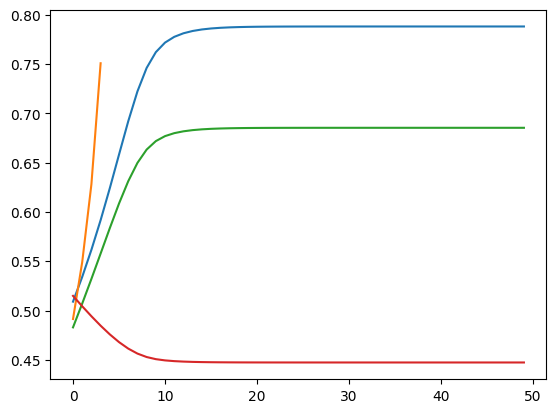

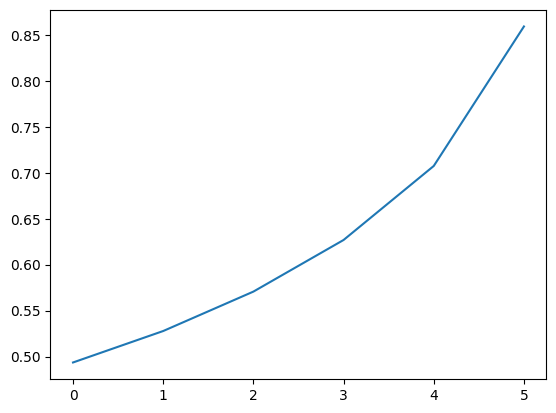

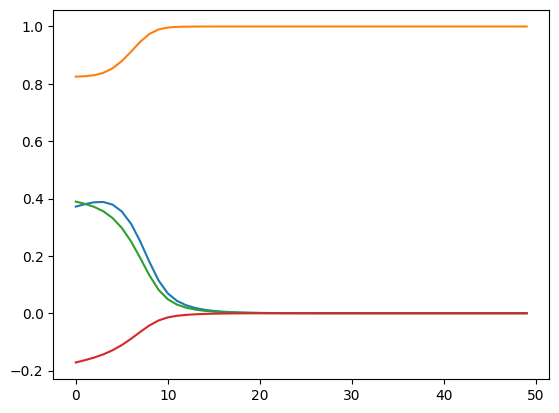

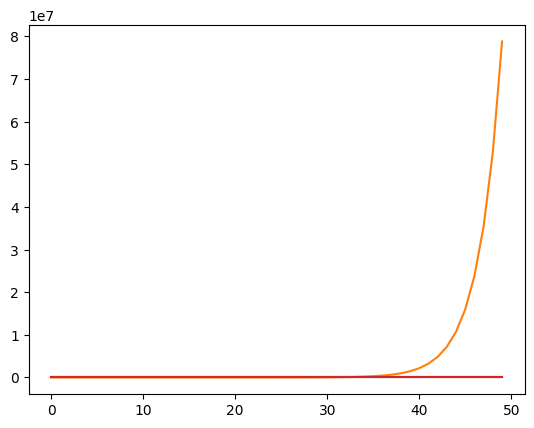

In [7]:
fig = plt.figure()
#for i in range(4):
    #plt.plot(ode_solver_nid.history['phase2']['R'][:,i,i]/np.sqrt(ode_solver_nid.history['phase2']['Q'][:,i,i])/np.sqrt(ode_solver_nid.S[i,i]))
plt.plot(ode_solver_nid.history['phase2']['P'])    
fig = plt.figure()
plt.plot(ode_solver_nid.history['phase2']['P_tilde'])

fig = plt.figure()
plt.plot(ode_solver_nid.history['phase2']['VS'])
fig = plt.figure()
for i in range(0,4):
    plt.plot(ode_solver_nid.history['phase2']['R'][:,i,i])
#a=[np.sqrt(np.sum(np.power(solver_nid.history['phase2']['VS'][i],2) * np.diag(solver_nid.history['phase2']['Q'][i])))/2 for i in range(200)]
#plt.plot(a)


In [18]:
np.sqrt(np.sum(solver_nid.VS*solver_nid.VS * np.diag(solver_nid.WS @ solver_nid.WS.T/1000)))

1.0

In [15]:
(solver_nid.WS * solver_nid.WS).shape

(4, 1000)

In [9]:
solver_nid.R

AttributeError: 'CurriculumCompositionalTaskSimulator' object has no attribute 'R'

In [24]:
np.linalg.norm(ode_solver_nid.history['phase2']['R'], axis=(1,2))

array([1.46633872e-01, 6.98805952e-01, 2.17892945e+00, 5.62752994e+00,
       1.33934589e+01, 3.06539710e+01, 6.89855549e+01, 1.54102314e+02,
       3.43103675e+02, 7.62778686e+02, 1.69466076e+03, 3.76389060e+03,
       8.35858357e+03, 1.85610285e+04, 4.12154000e+04, 9.15190824e+04,
       2.03217633e+05, 4.51242542e+05, 1.00197803e+06, 2.22487767e+06,
       4.94030747e+06, 1.09698774e+07, 2.43584445e+07, 5.40875513e+07,
       1.20100574e+08, 2.66681473e+08, 5.92162097e+08, 1.31488680e+09,
       2.91968586e+09, 6.48311741e+09, 1.43956622e+10, 3.19653458e+10,
       7.09785573e+10, 1.57606792e+11, 3.49963449e+11, 7.77088440e+11,
       1.72551289e+12, 3.83147476e+12, 8.50773059e+12, 1.88912845e+13,
       4.19478059e+13, 9.31444558e+13, 2.06825827e+14, 4.59253559e+14,
       1.01976544e+15, 2.26437343e+15, 5.02800627e+15, 1.11646104e+16,
       2.47908451e+16, 5.50476890e+16, 1.22232544e+17, 2.71415479e+17,
       6.02673884e+17, 1.33822806e+18, 2.97151477e+18, 6.59820269e+18,
      

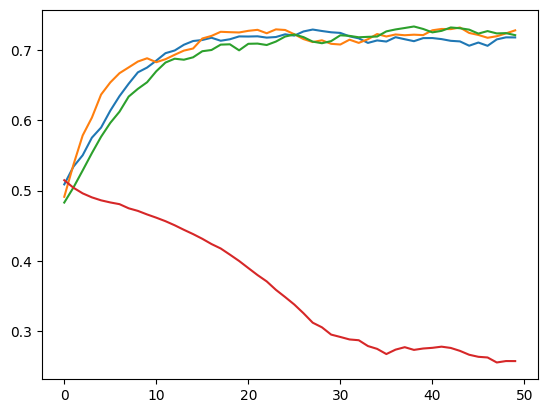

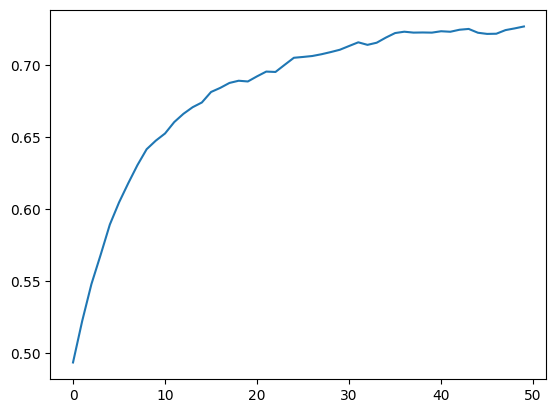

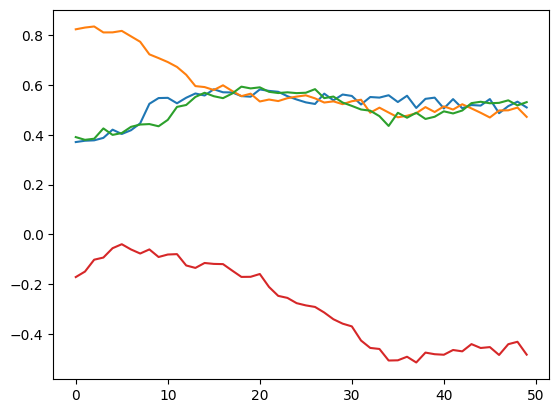

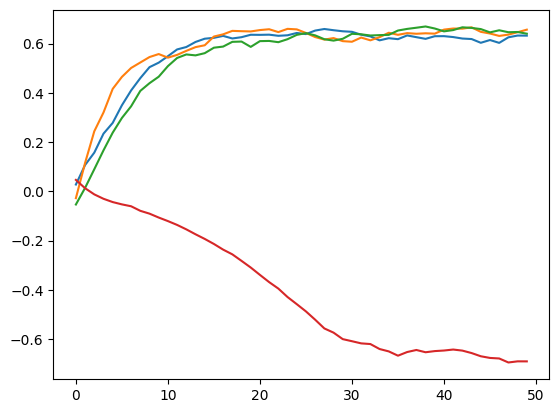

In [8]:
fig = plt.figure()
#for i in range(4):
    #plt.plot(ode_solver_nid.history['phase2']['R'][:,i,i]/np.sqrt(ode_solver_nid.history['phase2']['Q'][:,i,i])/np.sqrt(ode_solver_nid.S[i,i]))
plt.plot(solver_nid.history['P'])    
fig = plt.figure()
plt.plot(solver_nid.history['P_tilde'])

fig = plt.figure()
plt.plot(solver_nid.history['VS'])
fig = plt.figure()
for i in range(4):
    plt.plot(solver_nid.history['R'][:,i,i])


In [14]:
vt = [.2,.1,.1,.1,]
results = {}

for lr_v in [1]:
    results[lr_v]={}
    for lr_wc in [1]: 
        results[lr_v][lr_wc] = []
        for s in np.arange(1):
            VT_i= np.array(vt)
            VS_i =control_VS(VT_i, np.pi/4)
            _, WT_i =gram_schmidt(input_dim, num_task)
            WS_i = np.random.normal(0, .1, (num_task,input_dim))
            WS_i = np.divide(WS_i * np.sqrt(input_dim),
                                np.linalg.norm(WS_i, axis=1)[:, None])
            
            results[lr_v][lr_wc].append(ode_solver_nid)


array([-0.00211202,  0.11296742,  0.23191643,  0.35408583,  0.51533188,
        0.66566714,  0.76292673,  0.83521742,  0.86131511,  0.87099435,
        0.87593531,  0.87551494,  0.87685714,  0.8764117 ,  0.87705186,
        0.87760296,  0.87381437,  0.87266941,  0.876178  ,  0.87648359,
        0.87916853,  0.88166901,  0.87758923,  0.87998535,  0.87859927,
        0.87110692,  0.87095087,  0.87359113,  0.8787198 ,  0.8831547 ,
        0.88296709,  0.88070618,  0.8804261 ,  0.8727407 ,  0.87639384,
        0.87975262,  0.87733311,  0.87206273,  0.88367713,  0.87081846,
        0.87582862,  0.8760367 ,  0.88386798,  0.88153639,  0.87642541,
        0.87842276,  0.87732763,  0.87176249,  0.87724304,  0.88341629,
        0.87629253,  0.8778547 ,  0.87874534,  0.88532943,  0.87859864,
        0.86767108,  0.87068523,  0.8806182 ,  0.8727193 ,  0.87265364,
        0.86590616,  0.87194826,  0.87199589,  0.87364416,  0.86811751,
        0.8739059 ,  0.88604757,  0.88279163,  0.86807627,  0.87

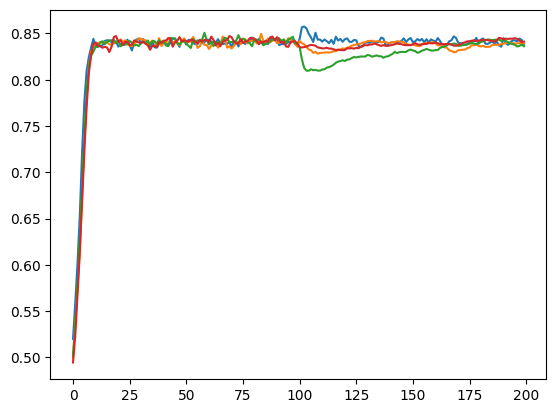

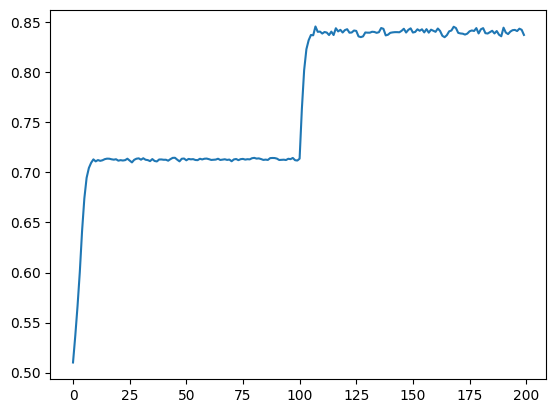

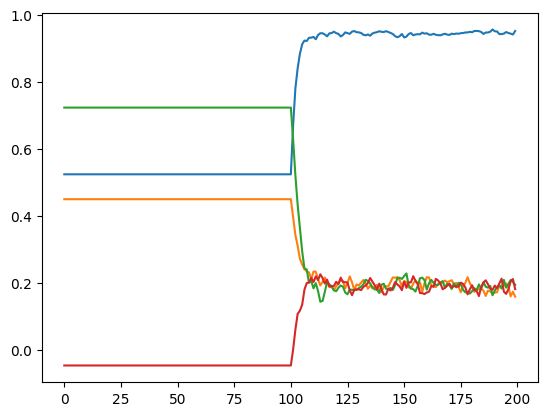

<Figure size 640x480 with 0 Axes>

In [25]:
fig = plt.figure()
#for i in range(4):
    #plt.plot(ode_solver_nid.history['phase2']['R'][:,i,i]/np.sqrt(ode_solver_nid.history['phase2']['Q'][:,i,i])/np.sqrt(ode_solver_nid.S[i,i]))
plt.plot(ode_solver_nid.history['P'])    
fig = plt.figure()
plt.plot(ode_solver_nid.history['P_tilde'])

fig = plt.figure()
plt.plot(ode_solver_nid.history['VS'])
fig = plt.figure()
ode_solver_nid.history['R'][:,1,1]


In [24]:
ode_solver_nid.history['R'][:,i,i]/np.sqrt(ode_solver_nid.history['Q'][:,i,i])

array([ 0.0279011 ,  0.11933577,  0.02691336,  0.08843294,  0.05939571,
        0.04938842,  0.03903628,  0.05783513,  0.07194361,  0.05127532,
        0.02301105,  0.05140271,  0.02845182,  0.01923199,  0.05287578,
        0.08995747,  0.09612248,  0.09925756,  0.07184931,  0.10725279,
        0.03776533,  0.04223077,  0.04128054,  0.05514653,  0.05267604,
        0.07577025,  0.01262868,  0.06689158,  0.07596873,  0.07168994,
        0.08152151,  0.01816984,  0.11260629,  0.09901513,  0.05798162,
        0.02508361,  0.08376456,  0.06096185, -0.01736809,  0.07632761,
        0.1059797 ,  0.02929846,  0.07747453,  0.05918504,  0.09626322,
        0.02867348,  0.08606079,  0.07824953,  0.05672734,  0.07096075,
        0.04170148, -0.0093013 ,  0.06648743,  0.04866719,  0.0721839 ,
        0.03448516,  0.08040384,  0.05378373,  0.04181972,  0.07969451,
        0.01618539,  0.03689602,  0.02515944,  0.06751744,  0.06396241,
        0.07227556,  0.05540428,  0.02685361,  0.06231177,  0.08

In [153]:
np.diag(np.ones((400,4,4)))

ValueError: Input must be 1- or 2-d.

In [143]:
solver_nid.history['phase2']['VS'][:,0]

array([0.94890005, 0.98866111, 0.99939675, 0.99989097, 0.99994068,
       0.99996051, 0.99997152, 0.99997837, 0.99998295, 0.99998618,
       0.99998856, 0.99999035, 0.99999174, 0.99999285, 0.99999374,
       0.99999447, 0.99999508, 0.99999559, 0.99999602, 0.99999639,
       0.99999671, 0.99999699, 0.99999723, 0.99999745, 0.99999764,
       0.99999781, 0.99999796, 0.99999809, 0.99999822, 0.99999833,
       0.99999843, 0.99999852, 0.9999986 , 0.99999868, 0.99999875,
       0.99999881, 0.99999887, 0.99999893, 0.99999898, 0.99999902,
       0.99999907, 0.99999911, 0.99999915, 0.99999918, 0.99999922,
       0.99999925, 0.99999928, 0.99999931, 0.99999933, 0.99999936,
       0.99999938, 0.9999994 , 0.99999942, 0.99999944, 0.99999946,
       0.99999948, 0.9999995 , 0.99999951, 0.99999953, 0.99999954,
       0.99999956, 0.99999957, 0.99999958, 0.99999959, 0.99999961,
       0.99999962, 0.99999963, 0.99999964, 0.99999965, 0.99999966,
       0.99999966, 0.99999967, 0.99999968, 0.99999969, 0.99999

In [129]:
solver_nid.history['VS'].shape

(100, 4)

In [31]:
a=[]
b= []
for i in range(1000):
    x = np.random.normal(loc=0.0,
                     scale=1.0,
                     size=(num_task, input_dim,
                                       seq_len))
    (y, y_sign, y_hat,
         y_hat_sign), (y_tilde, y_tilde_hat, y_tilde_sign,
                       y_tilde_hat_sign) = solver_nid.inference(x)
    b.append(y_tilde_sign == y_tilde_hat_sign)

0.97075

In [69]:
#Baseline version
#for i,vt in enumerate([np.random.normal(0,1, (4)), np.random.normal(0,1, (4)), np.random.normal(0,1, (4)), np.random.normal(0,1, (4))]):
vt = [.1,.1,.1,.1,]
results = {}
noise = 0.1
for lr_v in [0.01]:
    results[lr_v]={}
    for lr_wc in [0.001]: 
        results[lr_v][lr_wc] = []
        for s in np.arange(1):
            VT_i= np.array(vt)
            VS_i =control_VS(VT_i, np.pi/4)
            WT_i = np.random.normal(0, 0.001, (num_task,input_dim))*noise
            WS_i = WT_i.copy() + np.random.normal(0, 0.001, (num_task,input_dim))*noise
            ode_solver_nid = solver.CurriculumCompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len,
                                                                         num_task= num_task, identical = False,
                                                                         VS = VS_i, VT= VT_i, WS=WS_i, WT = WT_i)
            ode_solver_nid.train(lr = {'lr_w':1., 'lr_wc':lr_wc, 'lr_vc': lr_v},num_iter= nums_iter, update_frequency = update_frequency)
            results[lr_v][lr_wc].append(ode_solver_nid)


KeyboardInterrupt: 

In [ ]:
#plt.plot(ode_solver_nid.history['phase2']['VSVT'])
fig = plt.figure()
#for i in range(4):
    #plt.plot(ode_solver_nid.history['phase2']['R'][:,i,i]/np.sqrt(ode_solver_nid.history['phase2']['Q'][:,i,i])/np.sqrt(ode_solver_nid.S[i,i]))
plt.plot(ode_solver_nid.history['P'])    
fig = plt.figure()
plt.plot(ode_solver_nid.history['P_tilde'])

fig = plt.figure()
plt.plot(ode_solver_nid.history['VS'])

In [6]:
ode_solver_nid.VS

array([ 0.98953701,  0.10467909,  0.08993327, -0.04208089])

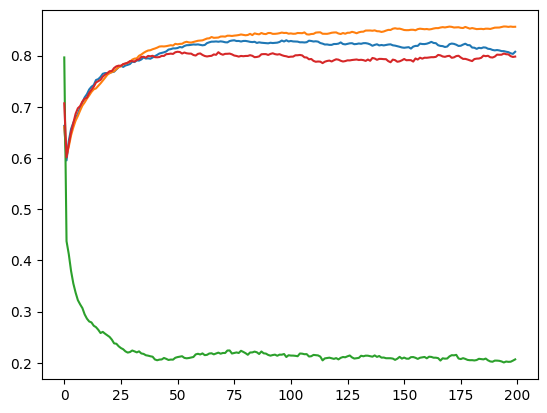

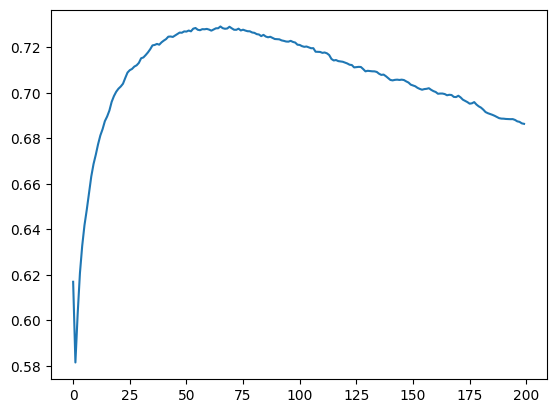

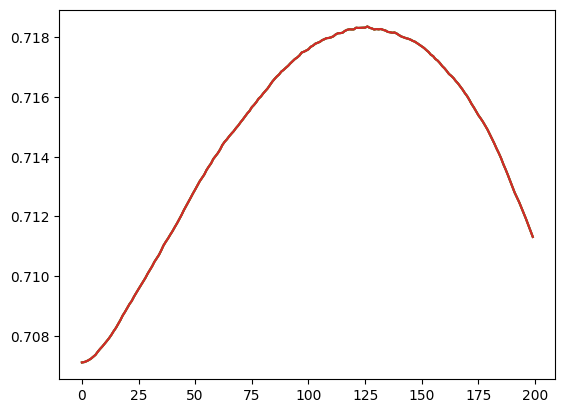

In [15]:
#plt.plot(ode_solver_nid.history['phase2']['VSVT'])
fig = plt.figure()
#for i in range(4):
    #plt.plot(ode_solver_nid.history['phase2']['R'][:,i,i]/np.sqrt(ode_solver_nid.history['phase2']['Q'][:,i,i])/np.sqrt(ode_solver_nid.S[i,i]))
plt.plot(ode_solver_nid.history['P'])    
fig = plt.figure()
plt.plot(ode_solver_nid.history['P_tilde'])

fig = plt.figure()
plt.plot(ode_solver_nid.history['VSVT'] )

In [19]:
ode_solver_nid.history.keys()

dict_keys(['Q', 'R', 'P', 'VS', 'P_tilde'])

In [175]:
np.dot([1,1,0,0],[1,0,0,0])/np.linalg.norm([1,1,0,0]/np.linalg.norm([1,0,0,0]))

0.7071067811865475

In [179]:
ode_solver_nid.VS

array([ 6.38287719, 89.95376501, -0.19975481, 62.18097277])

In [181]:
results = jl.load('curriculum_stability_1111_vsmallv.jl')

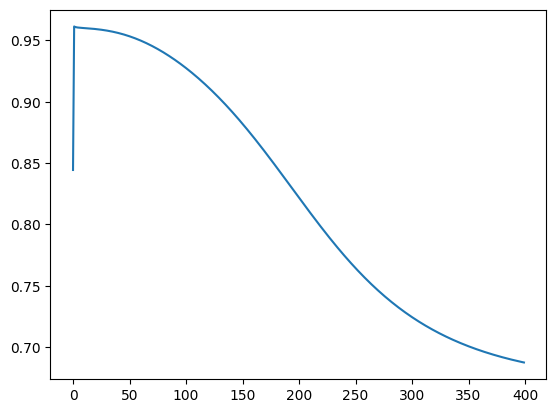

In [184]:
plt.plot(results[0.1][0.01][0].history['phase2']['P_tilde'])

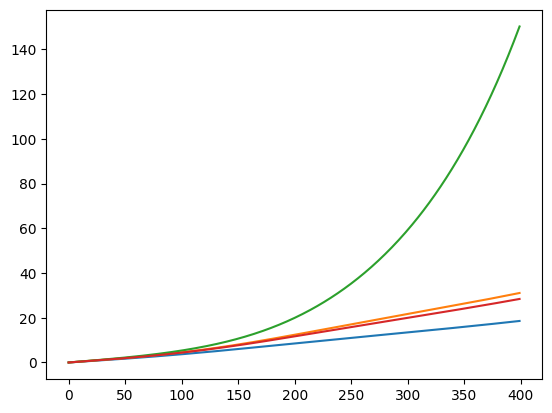

In [185]:
plt.plot(results[0.1][0.01][0].history['phase2']['VS'])

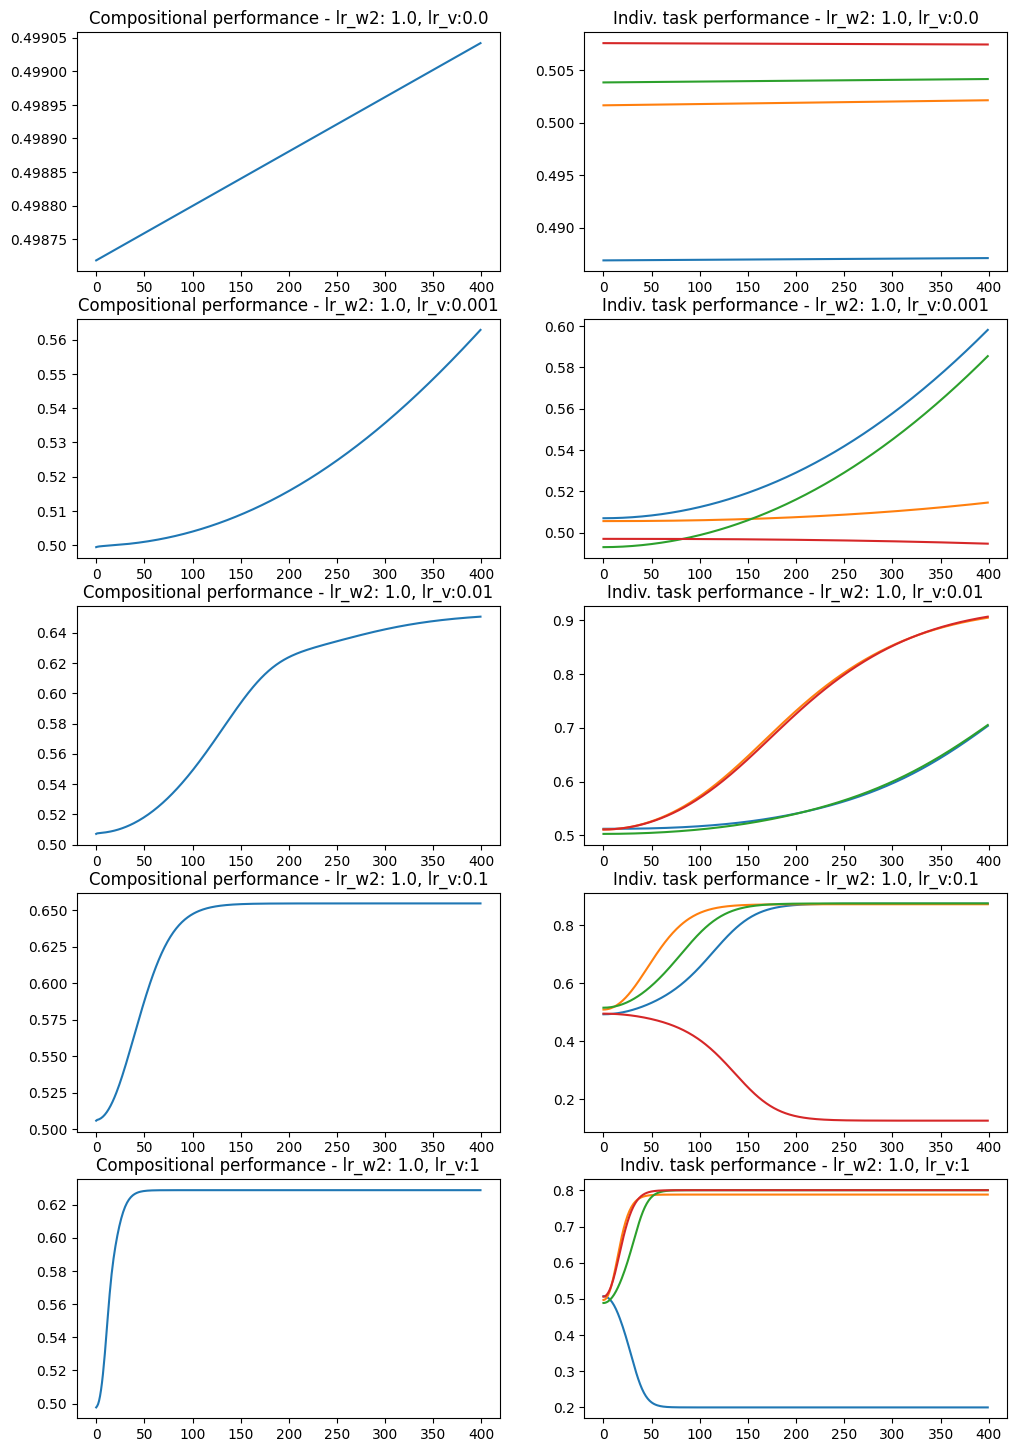

In [123]:
lr_w= 1.
fig, axs=plt.subplots(nrows = 5,ncols=2, figsize= (12,18))
for j, lr_v in enumerate([0., 0.001, 0.01, 0.1,1]): 
    axs[j][0].plot(np.array([r.history['phase2']['P_tilde'] for r in results[lr_v][lr_w]])[0].T)
    axs[j][1].plot(results[lr_v][lr_w][0].history['phase2']['P'])
    axs[j][0].set_title(f'Compositional performance - lr_w2: {lr_w}, lr_v:{lr_v}')
    axs[j][1].set_title(f'Indiv. task performance - lr_w2: {lr_w}, lr_v:{lr_v}')

In [ ]:
def gather_results(rootdir, identical):
    args = json.load(open(os.path.join(rootdir, 'args.json'), 'r'))
    ps = []
    pts= []
    if identical:
        identical_flag = 'id'
    else:
        identical_flag = 'nid'
    for path in glob.glob( rootdir+'/ode*'):
        ode=jl.load(path)
        p=ode[identical_flag]['phase2']['P']
        p_tilde=ode[identical_flag]['phase2']['P_tilde']
        vs=ode[identical_flag]['phase2']['VS'][0]
        #vt=ode[identical_flag]['VT']
        ps.append(p)
        pts.append(p_tilde)
        
    return np.array(ps), np.array(pts), args
        

In [ ]:
jl

hrl_ode_logs/230823_VTVS_noise/20230823195224.303622/
hrl_ode_logs/230823_VTVS_noise/20230823195224.303695/
hrl_ode_logs/230823_VTVS_noise/20230823195224.303676/
hrl_ode_logs/230823_VTVS_noise/20230823195224.303833/


/nfs/nhome/live/jlee/.conda/envs/composite_learning/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


hrl_ode_logs/230823_VTVS_noise/20230823195231.658186/
hrl_ode_logs/230823_VTVS_noise/20230823195231.658351/
hrl_ode_logs/230823_VTVS_noise/20230823195231.658131/
hrl_ode_logs/230823_VTVS_noise/20230823195231.658452/


/nfs/nhome/live/jlee/.conda/envs/composite_learning/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


hrl_ode_logs/230823_VTVS_noise/20230823195231.660193/
hrl_ode_logs/230823_VTVS_noise/20230823195231.660173/
hrl_ode_logs/230823_VTVS_noise/20230823195231.660146/
hrl_ode_logs/230823_VTVS_noise/20230823195231.660841/


/nfs/nhome/live/jlee/.conda/envs/composite_learning/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


hrl_ode_logs/230823_VTVS_noise/20230823195215.617745/
hrl_ode_logs/230823_VTVS_noise/20230823195224.055229/


/nfs/nhome/live/jlee/.conda/envs/composite_learning/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


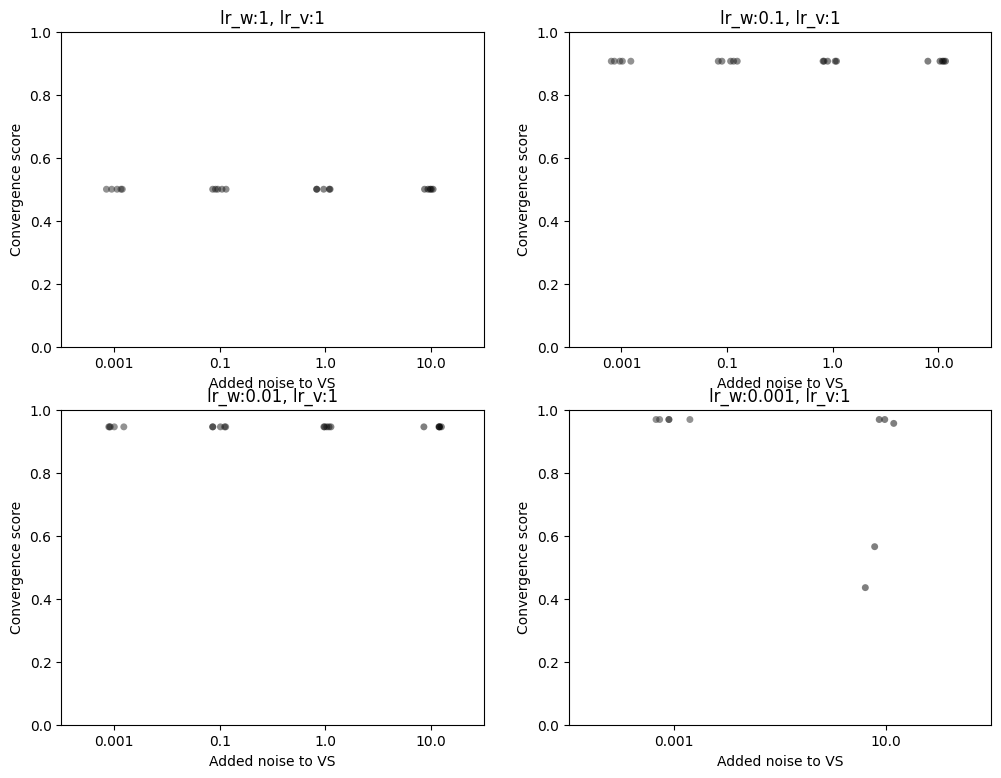

In [207]:
import glob
import joblib as jl
rootdirs=glob.glob('hrl_ode_logs/230823_VTVS_noise/*/')
lr_v = 1
fig, axs = plt.subplots(2,2, figsize=(12,9))
for i,lr_w in enumerate([1, 0.1, 0.01, 0.001]):
    res = {}
    for _, noise in enumerate([0.001,0.1, 1, 10]):
        for rootdir in rootdirs:
            ps, pts, args=gather_results(rootdir, identical = True)
            if args['lr_ws'] ==[0, lr_w] and args['lr_v'] ==lr_v and args['noise_scale']==noise:
                print(rootdir)
                res[noise]= pts[:,-1]

    ax = axs[i//2][i%2]
    sns.stripplot(res, ax = axs[i//2][i%2], color = 'k', alpha = 0.5)
    ax.set_title(f'lr_w:{lr_w}, lr_v:{lr_v}')
    ax.set_xlabel('Added noise to VS')
    ax.set_ylabel('Convergence score')
    ax.set_ylim([0,1])

        
        
        
    

In [212]:
pt=jl.load('hrl_ode_logs/230823_VTVS_noise/20230823195231.658186/ode_1.jl')['id']['phase2']['P_tilde']
p=jl.load('hrl_ode_logs/230823_VTVS_noise/20230823195231.658186/ode_1.jl')['id']['phase2']['P']

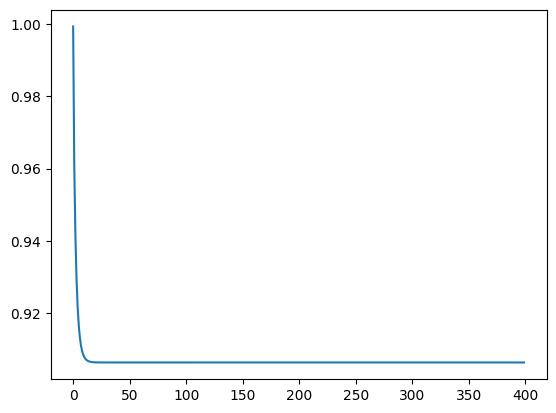

In [213]:
plt.plot(pt.T)

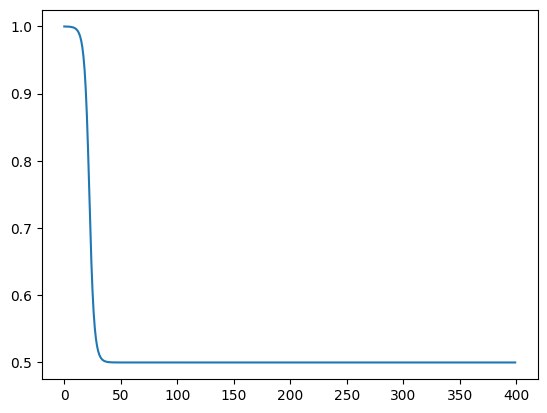

In [224]:
plt.plot(p.T[3])